In [11]:
!pip install pyhive thrift thrift_sasl pyspark pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 6.1 MB/s eta 0:00:02
   ----------------------- ---------------- 4.7/8.1 MB 13.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 17.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------- ------------------------- 0.8/2.2 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 5.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 23.9 MB/s eta 0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [pyparsing]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ------------

In [18]:
from pyhive import hive
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
conn = hive.Connection(
    host='localhost',
    port=10000,
    username='airflow',  
    database='default'
)

cursor = conn.cursor()

In [20]:
cursor.execute("SHOW TABLES")
print(cursor.fetchall())

[('customers',), ('monthly_sales_growth',), ('order',), ('order_line',), ('peak_order_hours',), ('product_sales',), ('products',), ('reservation',), ('reservations_by_date',), ('restaurant',), ('sales',), ('sales_by_mon',), ('sales_by_product',), ('weekly_reservation_patterns',)]


### Ventas Totales por Mes

In [23]:
cursor.execute("SELECT * FROM sales_by_mon")
results = cursor.fetchall()
df = pd.DataFrame(results, columns=['year', 'month', 'total_sales'])
df.head()

,year,month,total_sales
0,2025,5,2523.0
1,2025,6,7073.0


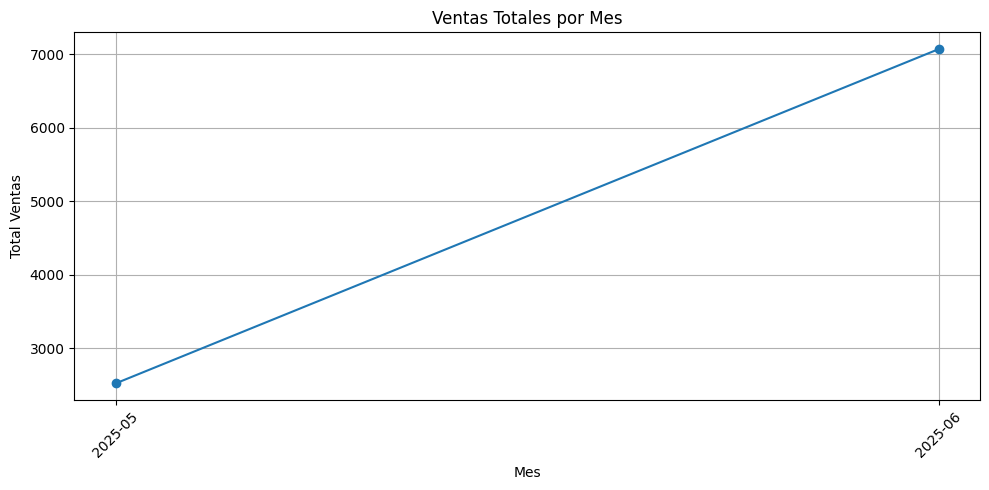

In [24]:
df_sorted = df.sort_values(["year", "month"])
df_sorted["year-month"] = df_sorted["year"].astype(str) + "-" + df_sorted["month"].astype(str).str.zfill(2)

plt.figure(figsize=(10, 5))
plt.plot(df_sorted["year-month"], df_sorted["total_sales"], marker='o')
plt.xticks(rotation=45)
plt.title("Ventas Totales por Mes")
plt.xlabel("Mes")
plt.ylabel("Total Ventas")
plt.tight_layout()
plt.grid(True)
plt.show()

### Ventas Totales por Producto

In [25]:
cursor.execute("SELECT * FROM sales_by_product")
results = cursor.fetchall()
df_sales_by_product = pd.DataFrame(results, columns=['product_name', 'total_sales'])
df_sales_by_product.head()

,product_name,total_sales
0,Bacon Bespoke,13.0
1,Bacon Fantastic,42.0
2,Bacon Generic,13.0
3,Bacon Recycled,27.0
4,Bacon Sleek,99.0


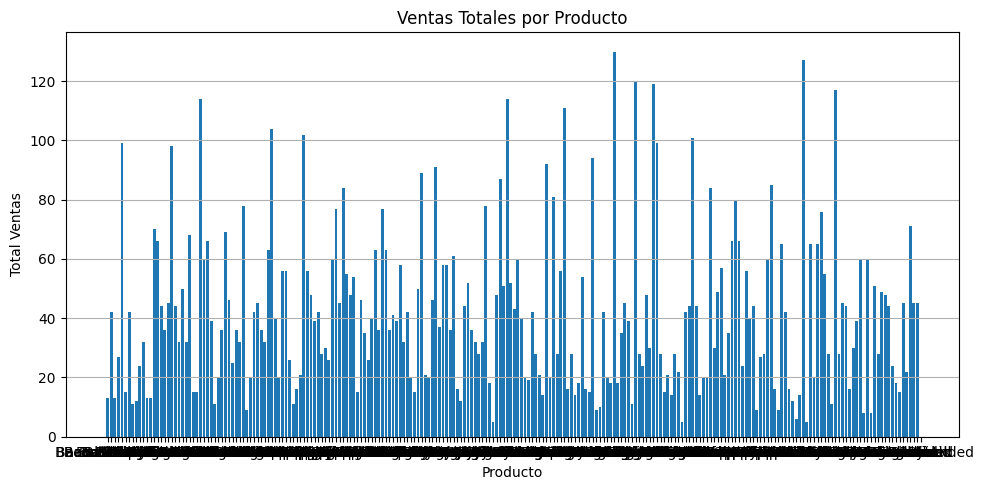

In [30]:
df = df_sales_by_product 
plt.figure(figsize=(10, 5))
plt.bar(df["product_name"], df["total_sales"])
plt.title("Ventas Totales por Producto")
plt.xlabel("Producto")
plt.ylabel("Total Ventas")
plt.tight_layout()
plt.grid(axis='y')
plt.show()

### Reservas por Fecha

In [31]:
cursor.execute("SELECT * FROM reservations_by_date")
results = cursor.fetchall()
df_reservations_by_date = pd.DataFrame(results, columns=['reservation_date', 'num_reservations'])
df_reservations_by_date.head()

,reservation_date,num_reservations
0,None,1
1,2025-06-23,16
2,2025-06-24,17
3,2025-06-25,11
4,2025-06-26,17


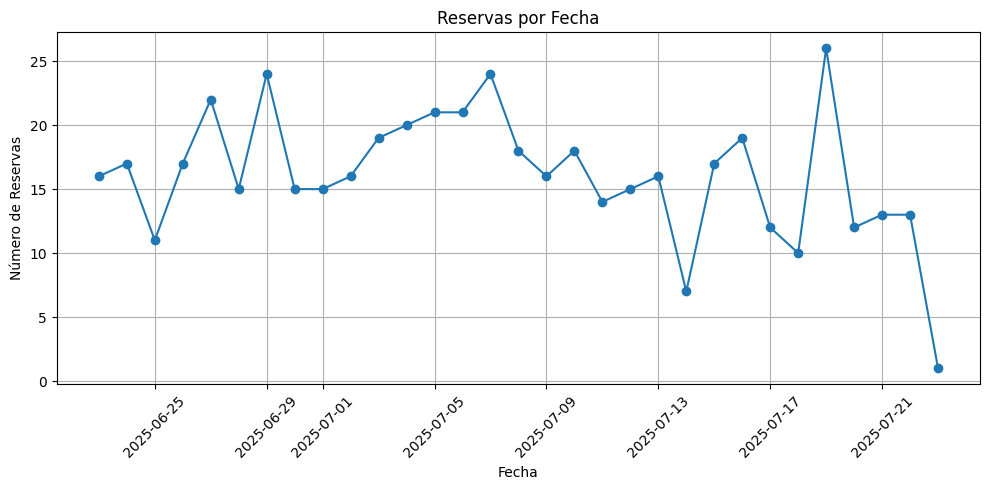

In [32]:
df=df_reservations_by_date
df["reservation_date"] = pd.to_datetime(df["reservation_date"])
plt.figure(figsize=(10, 5))
plt.plot(df["reservation_date"], df["num_reservations"], marker='o')
plt.title("Reservas por Fecha")
plt.xlabel("Fecha")
plt.ylabel("Número de Reservas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

### Crecimiento Mensual de Ventas

In [33]:
cursor.execute("SELECT * FROM monthly_sales_growth")
results = cursor.fetchall()
df_monthly_sales_growth = pd.DataFrame(results, columns=['year', 'month', 'total_sales'])
df_monthly_sales_growth.head()

,year,month,total_sales
0,NaN,NaN,NaN
1,2025.0,5.0,2523.0
2,2025.0,6.0,7073.0


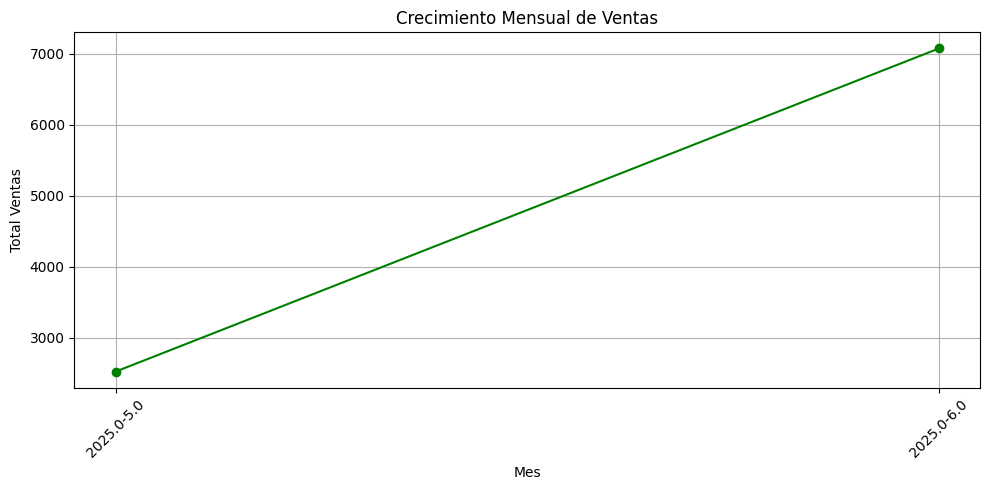

In [34]:
df = df_monthly_sales_growth
df_sorted = df.sort_values(["year", "month"])
df_sorted["year-month"] = df_sorted["year"].astype(str) + "-" + df_sorted["month"].astype(str).str.zfill(2)

plt.figure(figsize=(10, 5))
plt.plot(df_sorted["year-month"], df_sorted["total_sales"], marker='o', color='green')
plt.xticks(rotation=45)
plt.title("Crecimiento Mensual de Ventas")
plt.xlabel("Mes")
plt.ylabel("Total Ventas")
plt.tight_layout()
plt.grid(True)
plt.show()

### Horas Pico de Órdenes

In [35]:
cursor.execute("SELECT * FROM peak_order_hours")
results = cursor.fetchall()
df_peak_order_hours = pd.DataFrame(results, columns=['hour', 'order_count'])
df_peak_order_hours.head()

,hour,order_count
0,NaN,1
1,0.0,24
2,1.0,26
3,2.0,21
4,3.0,20


C:\Users\marin\AppData\Local\Temp\ipykernel_18720\2349283504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour"] = df["hour"].astype(int)


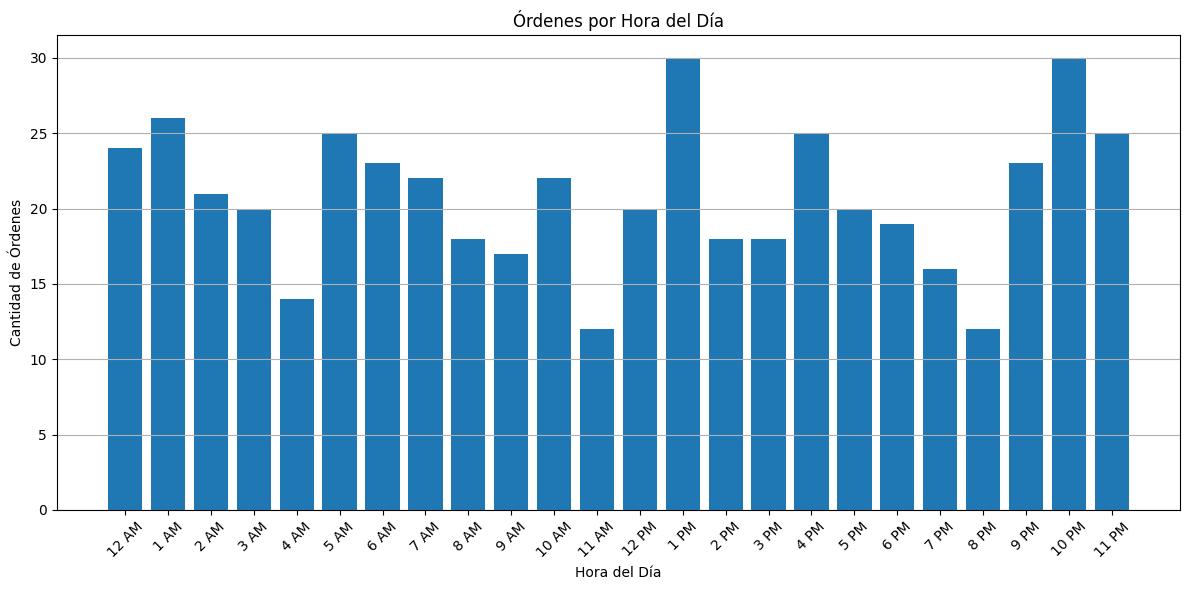

In [42]:
df = df_peak_order_hours.dropna()
df["hour"] = df["hour"].astype(int)
labels = [f"{(h % 12 or 12)} {'AM' if h < 12 else 'PM'}" for h in df["hour"]]
plt.figure(figsize=(12, 6))
plt.bar(labels, df["order_count"])
plt.title("Órdenes por Hora del Día")
plt.xlabel("Hora del Día")
plt.ylabel("Cantidad de Órdenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

### Patrón Semanal de Reservas

In [37]:
cursor.execute("SELECT * FROM weekly_reservation_patterns")
results = cursor.fetchall()
df_weekly_reservation_patterns = pd.DataFrame(results, columns=['weekday', 'total_reservations'])
df_weekly_reservation_patterns.head()

,weekday,total_reservations
0,NaN,1
1,1.0,73
2,2.0,75
3,3.0,80
4,4.0,63


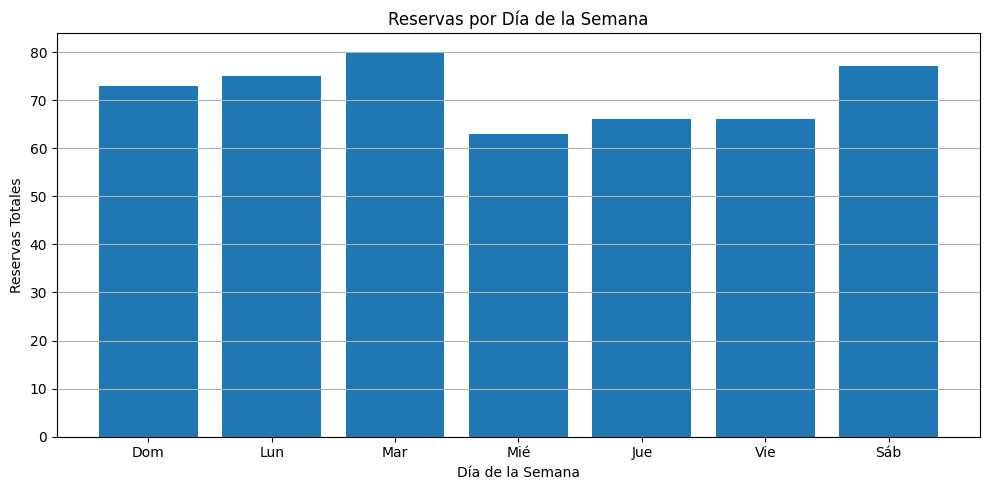

In [38]:
df = df_weekly_reservation_patterns
weekday_labels = ['Dom', 'Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb']

plt.figure(figsize=(10, 5))
plt.bar(df["weekday"], df["total_reservations"])
plt.title("Reservas por Día de la Semana")
plt.xlabel("Día de la Semana")
plt.ylabel("Reservas Totales")
plt.xticks(ticks=range(1, 8), labels=weekday_labels)
plt.tight_layout()
plt.grid(axis='y')
plt.show()